# Visualizing intermediate activations

In [18]:
import numpy as np
from keras import models
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot as plt

In [19]:
import os

cur_dir = os.getcwd()

In [20]:
model = models.load_model(os.path.join(cur_dir, 'cats_and_dogs_small.h5'))

OSError: Unable to open file (Unable to open file: name = '/users/mbp2016/pycharmprojects/cnn_visualizing/cats_and_dogs_small.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

In [ ]:
img = load_img('input/dog.jpg', target_size=(150, 150))
img_tensor = img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

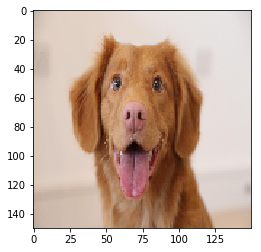

In [5]:
plt.imshow(img_tensor[0])
plt.show()

In [6]:
layers_output = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.inputs, outputs=layers_output)

In [7]:
activations = activation_model.predict(img_tensor)

In [8]:
# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[:8]]

/Users/mbp2016/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


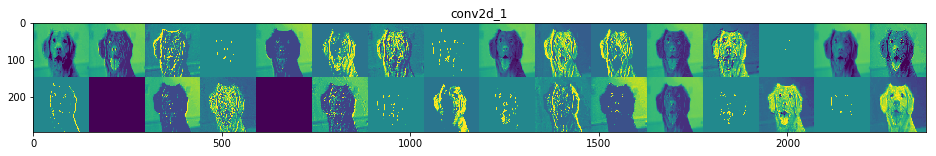

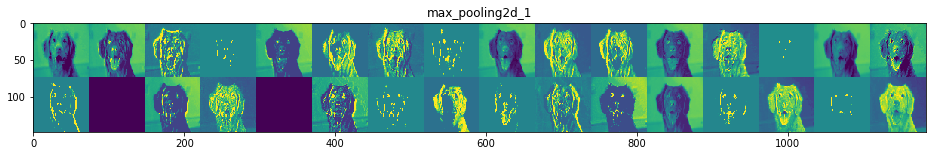

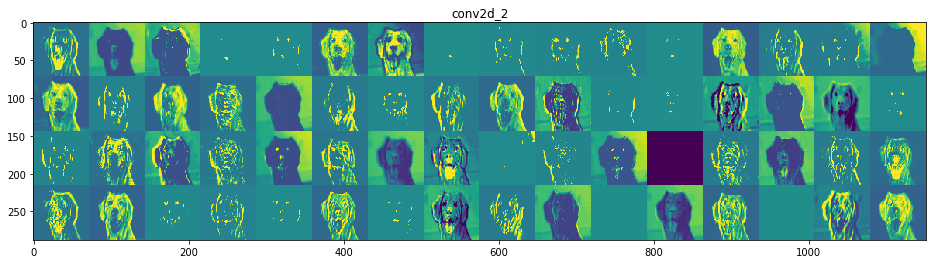

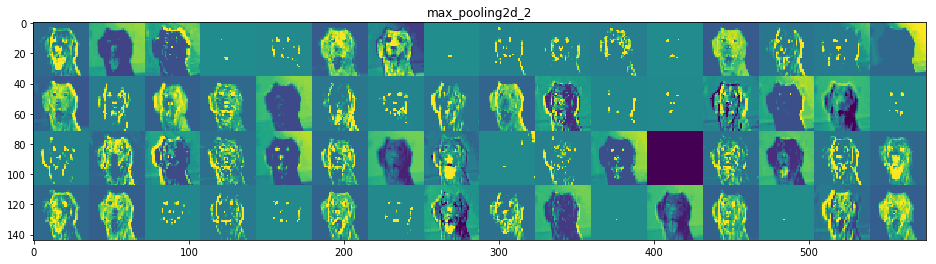

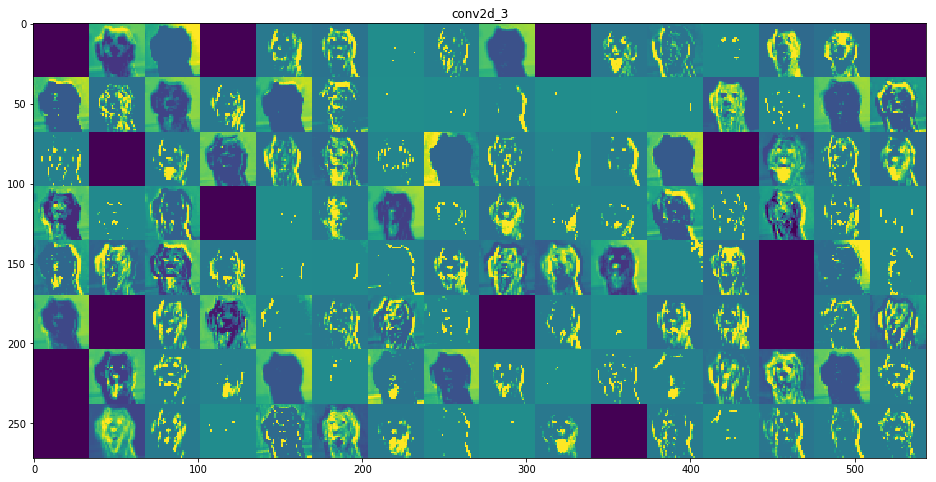

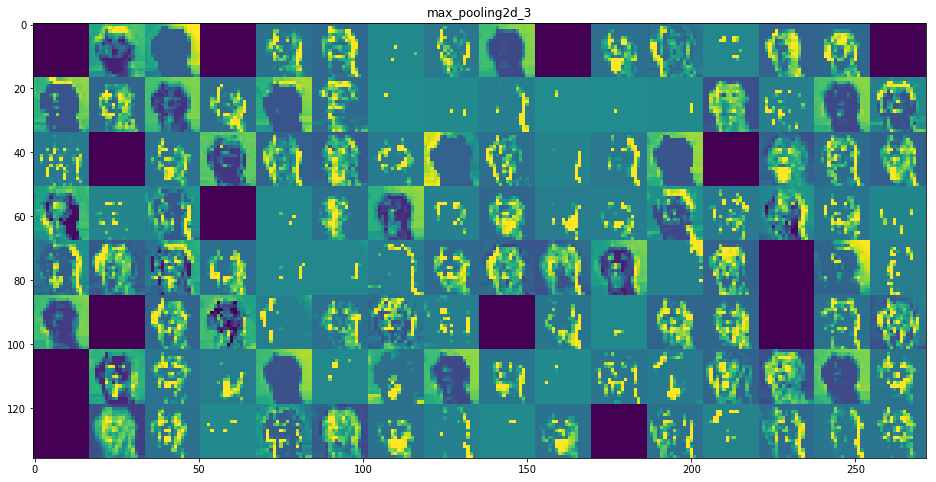

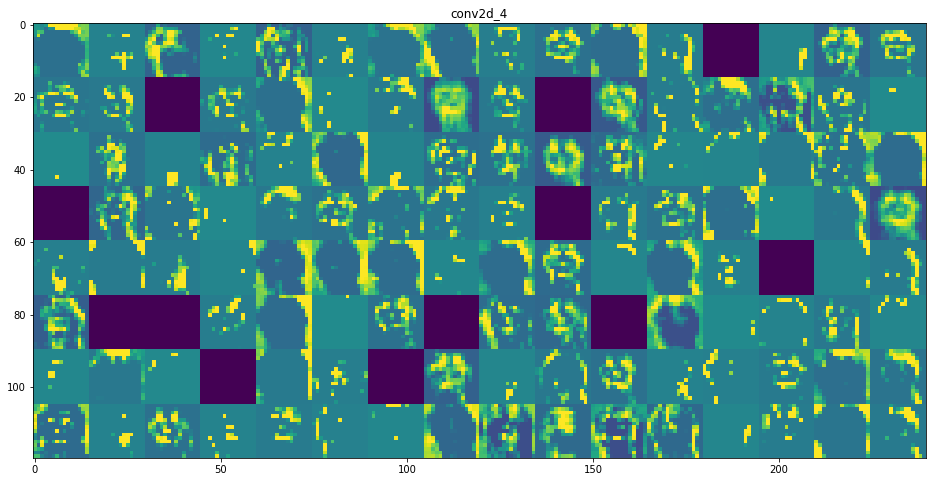

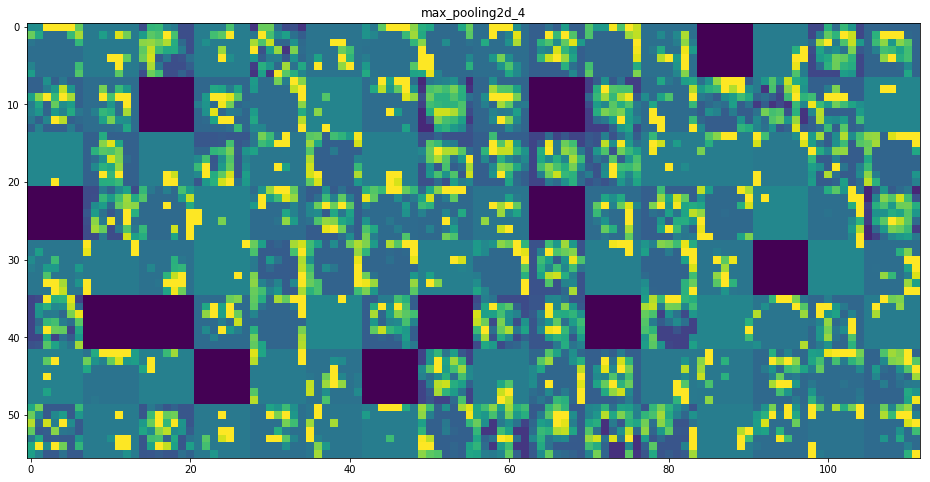

In [9]:
images_per_row = 16

# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size: (col + 1) * size,
            row * size: (row + 1) * size] = channel_image

    # Display the grid
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

# Visualizing convnet filters

In [10]:
import os

from keras import backend as K
from keras import models
from keras.applications import VGG16
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np

cur_dir = os.getcwd()
model = VGG16(weights='imagenet', include_top=False)

model.summary()

model = models.load_model(os.path.join(cur_dir, 'cats_and_dogs_small.h5'))




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [12]:
layer_names = [layer.name for layer in model.layers[:8]]

In [13]:
layer_names

['conv2d_1',
 'max_pooling2d_1',
 'conv2d_2',
 'max_pooling2d_2',
 'conv2d_3',
 'max_pooling2d_3',
 'conv2d_4',
 'max_pooling2d_4']

In [14]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x


def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])

    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20

    # Run gradient ascent for 40 steps
    step = 100.
    for i in range(50):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

    img = input_img_data[0]
    return deprocess_image(img)



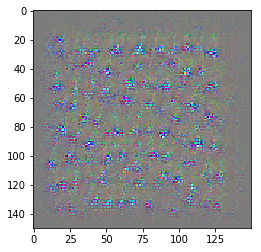

In [ ]:
plt.imshow(generate_pattern('conv2d_4', 26))
plt.show()

100%|██████████| 8/8 [00:01<00:00,  4.54it/s]


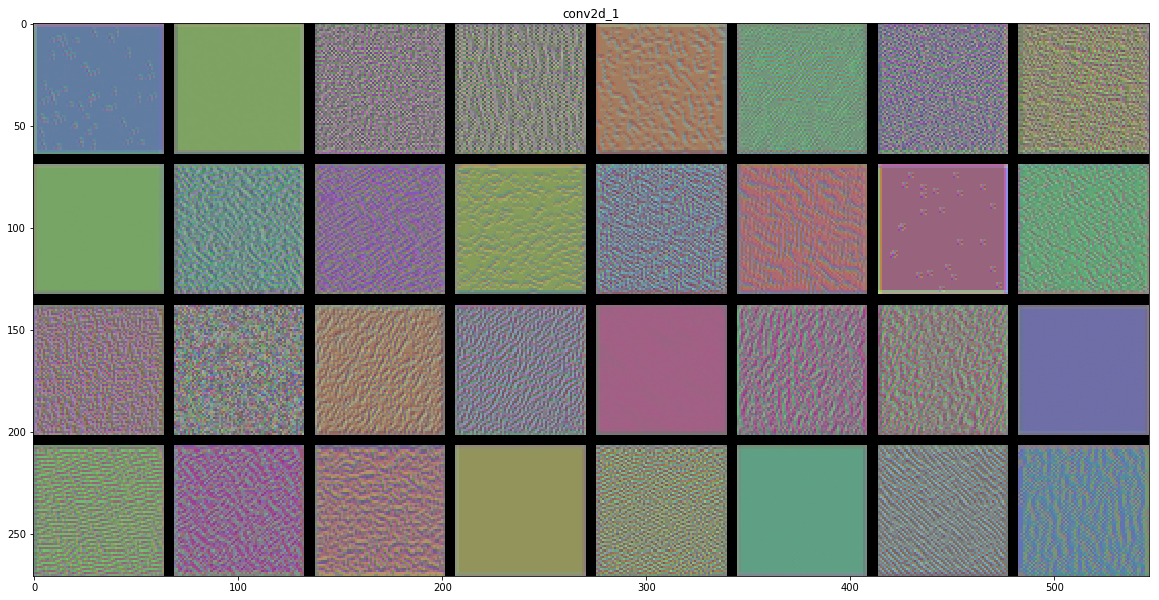

100%|██████████| 8/8 [00:02<00:00,  3.17it/s]


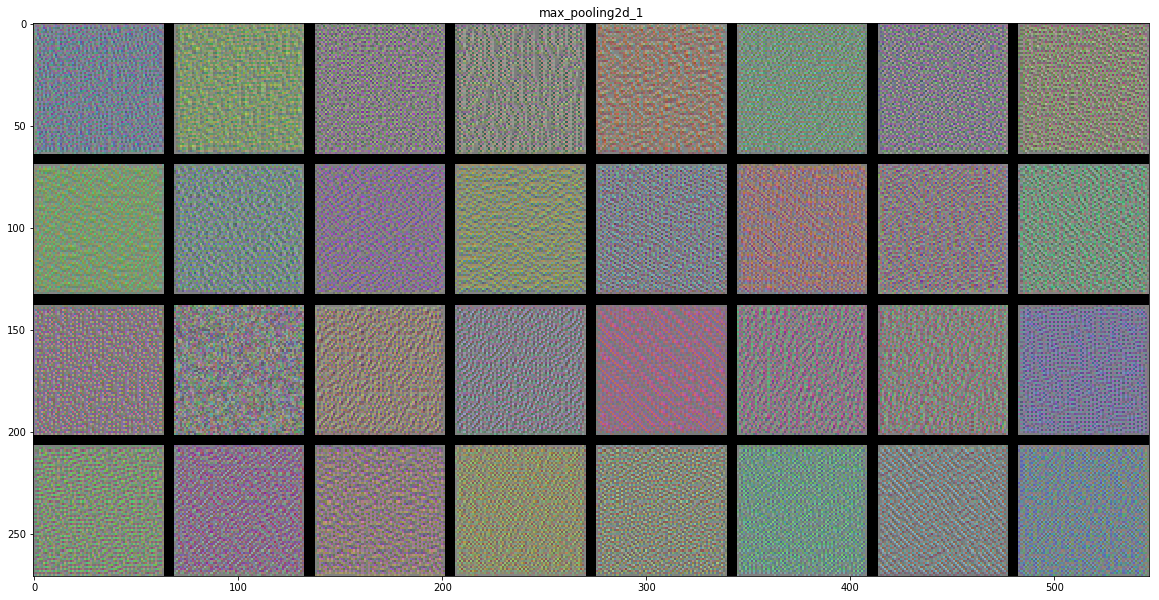

100%|██████████| 8/8 [00:03<00:00,  2.06it/s]


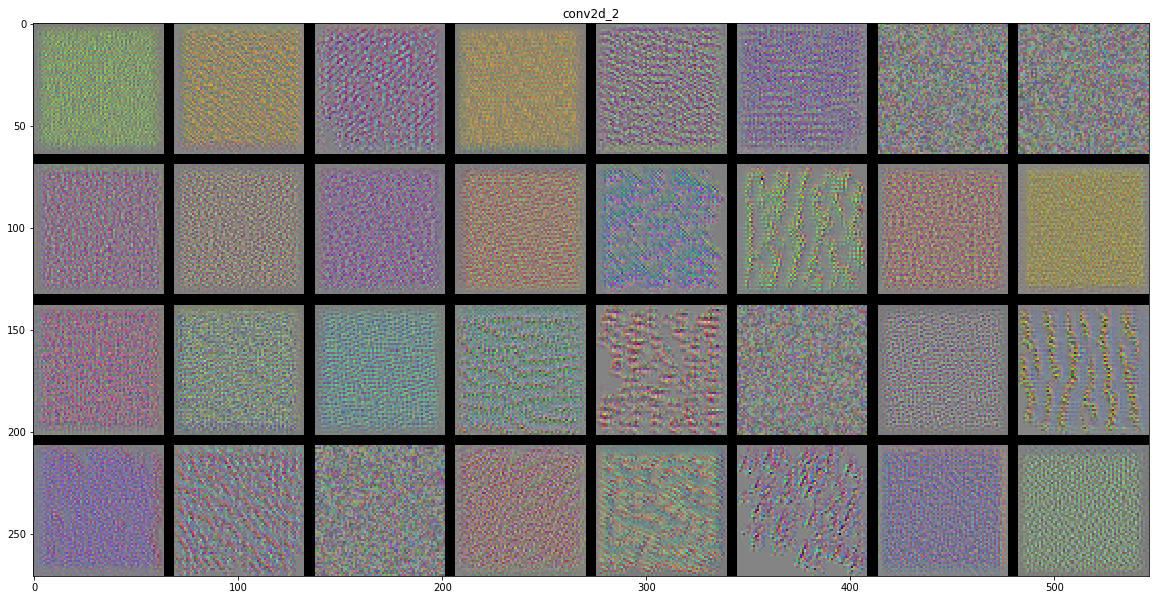

100%|██████████| 8/8 [00:03<00:00,  2.07it/s]


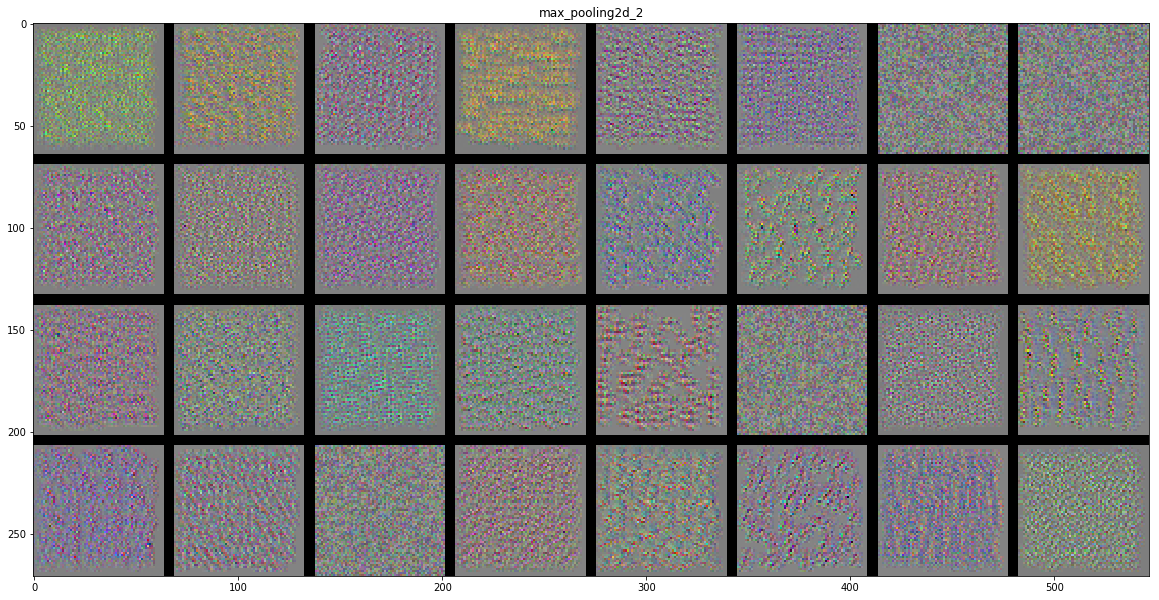

100%|██████████| 8/8 [00:04<00:00,  1.71it/s]


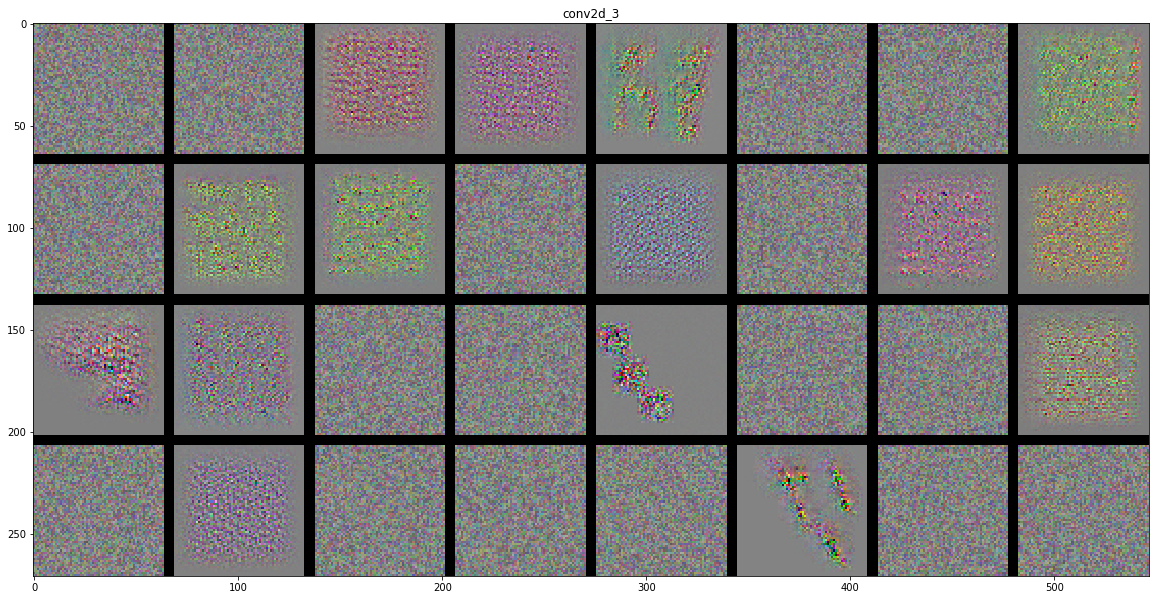

100%|██████████| 8/8 [00:05<00:00,  1.49it/s]


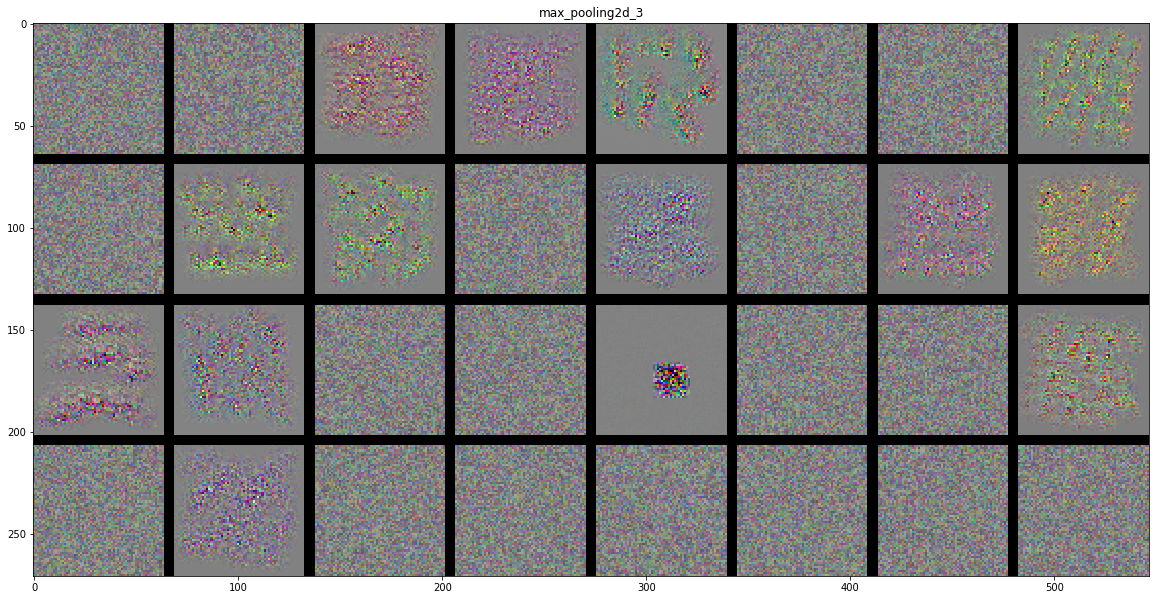

 38%|███▊      | 3/8 [00:02<00:03,  1.32it/s]

In [ ]:
for layer_name in layer_names:
    size = 64
    margin = 5

    # This a empty (black) image where we will store our results.
    results = np.zeros((4 * size + 3 * margin, 8 * size + 7 * margin, 3))

    for i in range(4):  # iterate over the rows of our results grid
        for j in tqdm(range(8)):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, j + (i * 8), size=size)

            # Put the result in the square `(i, j)` of the results grid
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # Display the results grid
    plt.figure(figsize=(20, 20))
    plt.title(layer_name)
    plt.imshow(results)
    plt.show()

In [ ]:
model.predict(img_tensor)